In [1]:
%matplotlib inline

### Load all the halos in the Bolshoi-Planck dataset

In [2]:
from load_um_sfh_data import load_bpl_data
halos, bpl_t, bpl_z = load_bpl_data()
print(halos.keys())

['a_first_infall', 'a_last_infall', 'halo_id', 'upid', 'sfr_history_all_prog', 'logmpeak', 'sfr_history_main_prog', 'sm_history_main_prog', 'log_mah', 'tmp', 'log_dmhdt']


### Load the results written to disk by `history_fitting_script.py `

In [3]:
import h5py
fitting_data = dict()
fn = "test_fixed_logmp.h5"
with h5py.File(fn, 'r') as hdf:
    for key in hdf.keys():
        if key == 'halo_id':
            fitting_data[key] = hdf[key][...]
        else:
            fitting_data['fit_'+key] = hdf[key][...]
print(fitting_data.keys())
print("\nNumber of objects in {0} = {1}".format(fn, len(fitting_data['halo_id'])))

dict_keys(['fit_dmhdt_early_index', 'fit_dmhdt_k', 'fit_dmhdt_late_index', 'fit_dmhdt_x0', 'halo_id', 'fit_logmp', 'fit_loss', 'fit_tmp'])

Number of objects in test_fixed_logmp.h5 = 10


### Cross-match the two datasets using the `halo_id`

I use halotools for this, but there are many ways to do this.

In [4]:
from halotools.utils import crossmatch
idxA, idxB = crossmatch(fitting_data['halo_id'], halos['halo_id'])

for key in halos.keys():
    if key != 'halo_id':
        fitting_data[key] = np.zeros_like(halos[key])
        fitting_data[key][idxA] = halos[key][idxB]        

keys_to_inherit = ('dmhdt_x0', 'dmhdt_k', 'dmhdt_early_index', 'dmhdt_late_index')
print(fitting_data.keys())
print("\nNumber of objects in fitting_data = {0}".format(len(fitting_data['halo_id'])))# for key in keys_to_inherit:

dict_keys(['fit_dmhdt_early_index', 'fit_dmhdt_k', 'fit_dmhdt_late_index', 'fit_dmhdt_x0', 'halo_id', 'fit_logmp', 'fit_loss', 'fit_tmp', 'a_first_infall', 'a_last_infall', 'upid', 'sfr_history_all_prog', 'logmpeak', 'sfr_history_main_prog', 'sm_history_main_prog', 'log_mah', 'tmp', 'log_dmhdt'])

Number of objects in fitting_data = 10


### Use `jax.vmap` to generate predictions for each best-fitting model

In [18]:
from jax import vmap
from diffmah.halo_assembly import _individual_halo_assembly_jax_kern
from diffmah.halo_assembly import _get_dt_array

halo_histories_from_fitting_data = vmap(
    _individual_halo_assembly_jax_kern, in_axes=(None, None, 0, 0, 0, 0, 0, 0),
)

logt = np.log10(bpl_t)
dtarr = _get_dt_array(bpl_t)
logmp = fitting_data['fit_logmp']
dmhdt_x0 = fitting_data['fit_dmhdt_x0']
dmhdt_k = fitting_data['fit_dmhdt_k']
early = fitting_data['fit_dmhdt_early_index']
late = fitting_data['fit_dmhdt_late_index']
indx_tmp = np.searchsorted(bpl_t, fitting_data['fit_tmp'])

args = (logt,
        dtarr,
        logmp,
        dmhdt_x0,
        dmhdt_k,
        early,
        late,
        indx_tmp)

log_mah_pred, log_dmhdt_pred = halo_histories_from_fitting_data(*args)
np.shape(log_mah_pred)
fitting_data['log_mah_pred'] = log_mah_pred
fitting_data['log_dmhdt_pred'] = log_dmhdt_pred
print(fitting_data.keys())

### Check the fit of some random halo

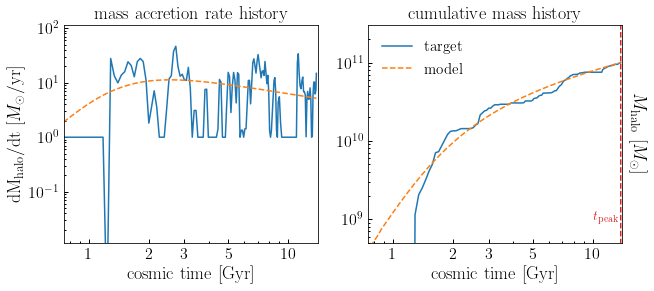

In [116]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
xlim = ax0.set_xlim(0.75, 14)

itest = np.random.randint(0, len(fitting_data['fit_logmp']))

__=ax0.loglog()
__=ax1.loglog()
__=ax0.plot(bpl_t, 10**fitting_data['log_dmhdt'][itest, :], label=r'${\rm target}$')
__=ax0.plot(bpl_t, 10**fitting_data['log_dmhdt_pred'][itest, :], '--', label=r'${\rm model}$')

__=ax1.plot(bpl_t, 10**fitting_data['log_mah'][itest, :], label=r'${\rm target}$')
__=ax1.plot(bpl_t, 10**fitting_data['log_mah_pred'][itest, :], '--', label=r'${\rm model}$')

ymin0 = 10**fitting_data['log_dmhdt_pred'][itest, :].min()
ymax0 = 10**fitting_data['log_dmhdt_pred'][itest, :].max()
ymax1 = 10**fitting_data['log_mah_pred'][itest, :].max()
ymin1 = ymax1/200

ylim0= ax0.set_ylim(ymin0/10, 10*ymax0)
ylim1= ax1.set_ylim(ymin1, 3*ymax1)


leg1 = ax1.legend()

xlabel0 = ax0.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
xlabel1 = ax1.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel0 = ax0.set_ylabel(r'${\rm dM_{halo}/dt}\ [M_{\odot}/{\rm yr}]$')
__=ax1.yaxis.set_label_position("right")  #  y-labels on the right
ylabel1 = ax1.set_ylabel(r'$M_{\rm halo}\ [M_{\odot}]$', rotation=-90, labelpad=25)

title = ax0.set_title(r'${\rm mass\ accretion\ rate\ history}$')
title = ax1.set_title(r'${\rm cumulative\ mass\ history}$')

from matplotlib import ticker
for ax in (ax0, ax1):
    __=ax.set_xticks((1, 2, 3, 5, 10))
    __=ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    __=ax.get_xaxis().set_minor_formatter(ticker.NullFormatter())
    __=ax.set_xticklabels([r'$1$', r'$2$', r'$3$', r'$5$', r'$10$'])
    
tmp_itest = fitting_data['tmp'][itest]
__=ax1.plot(np.zeros(5000) + tmp_itest, np.logspace(0, 20, 5000), '--', color=mred)
a, b = min(10, tmp_itest-1.5), ymin1*2
# a, b = 10, 10**10
__=ax.annotate(r'$t_{\rm peak}$', xy=(a, b), xytext=(a, b), size=14, color=mred)

fig.savefig('inspect_mah_fit.png', bbox_extra_artists=[xlabel0, ylabel0], 
            bbox_inches='tight', dpi=200)